# torch.nnを用いたディープラーニングモデルの実装方法
https://colab.research.google.com/github/YutaroOgawa/pytorch_tutorials_jp/blob/main/notebook/1_Learning%20PyTorch/1_6_nn_tutorial_jp.ipynb

In [1]:
import pathlib

import requests

DATA_PATH = pathlib.Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)
URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILE_NAME = "mnist.pkl.gz"

if not (PATH / FILE_NAME).exists():
    content = requests.get(URL + FILE_NAME).content
    (PATH / FILE_NAME).open("wb").write(content)

In [2]:
import gzip
import pickle

with gzip.open((PATH / FILE_NAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

5
(50000, 784)


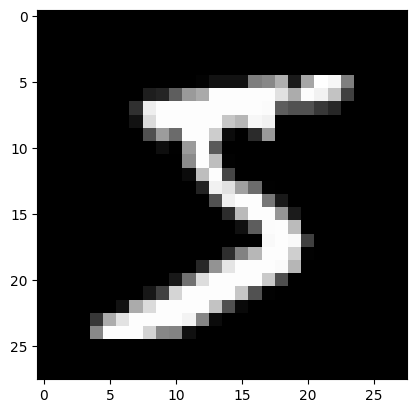

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(y_train[0])
print(x_train.shape)

In [4]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [5]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [6]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)


def model(xb):
    return log_softmax(xb @ weights + bias)

In [7]:
bs = 64

xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.3283, -2.6751, -1.8593, -2.1782, -2.8514, -2.5767, -2.0578, -2.9548,
        -1.8932, -2.2984], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [8]:
def nil(input, target):
    return -input[range(target.shape[0]), target].mean()


loss_fn = nil

In [9]:
yb = y_train[0:bs]
print(loss_fn(preds, yb))

tensor(2.2699, grad_fn=<NegBackward0>)


In [10]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [11]:
print(accuracy(preds, yb))

tensor(0.1562)


In [12]:
from IPython.core.debugger import set_trace

lr = 0.05
epochs = 10

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        # set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()

        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [13]:
print(loss_fn(model(xb), yb), accuracy(model(xb), yb))

tensor(0.3614, grad_fn=<NegBackward0>) tensor(0.8750)


In [14]:
import torch.nn.functional as F

loss_fn = F.cross_entropy


def model(xb):
    return xb @ weights + bias

In [15]:
print(loss_fn(model(xb), yb), accuracy(model(xb), yb))

tensor(0.3614, grad_fn=<NllLossBackward0>) tensor(0.8750)


In [16]:
from torch import nn


class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [17]:
model = Mnist_Logistic()

In [18]:
print(loss_fn(model(xb), yb))

tensor(2.4353, grad_fn=<NllLossBackward0>)


In [19]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_fn(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()


fit()

In [20]:
print(loss_fn(model(xb), yb), accuracy(model(xb), yb))

tensor(0.3679, grad_fn=<NllLossBackward0>) tensor(0.8750)


In [21]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

In [22]:
model = Mnist_Logistic()
print(loss_fn(model(xb), yb), accuracy(model(xb), yb))

tensor(2.3751, grad_fn=<NllLossBackward0>) tensor(0.1250)


In [23]:
fit()
print(loss_fn(model(xb), yb), accuracy(model(xb), yb))

tensor(0.3742, grad_fn=<NllLossBackward0>) tensor(0.8750)


In [30]:
from torch import optim


def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)


model, opt = get_model()
print(loss_fn(model(xb), yb), accuracy(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()
print(loss_fn(model(xb), yb), accuracy(model(xb), yb))

tensor(2.3083, grad_fn=<NllLossBackward0>) tensor(0.0625)
tensor(0.3663, grad_fn=<NllLossBackward0>) tensor(0.8750)


In [31]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)

In [33]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs : i * bs + bs]
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_fn(model(xb), yb))

tensor(0.3737, grad_fn=<NllLossBackward0>)


In [36]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [37]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_fn(model(xb), yb))

tensor(0.3661, grad_fn=<NllLossBackward0>)


In [38]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [39]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_fn(model(xb), yb) for xb, yb in valid_dl)
    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3805)
1 tensor(0.3351)
2 tensor(0.3154)
3 tensor(0.3050)
4 tensor(0.2973)
5 tensor(0.2926)
6 tensor(0.2870)
7 tensor(0.2832)
8 tensor(0.2822)
9 tensor(0.2786)


In [40]:
def loss_batch(model, loss_fn, xb, yb, opt=None):
    loss = loss_fn(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(xb)

In [47]:
import numpy as np


def fit(epochs, model, loss_fn, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_fn, xb, yb, opt)
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_fn, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [48]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [49]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

0 0.385449887418747
1 0.33960780625343323
2 0.3197129288434982
3 0.3071687675595284
4 0.3001155371427536
5 0.293818745970726
6 0.290429777264595
7 0.2866578489303589
8 0.28368737280368805
9 0.28104756252765656


In [52]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))


lr = 0.1

In [53]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

0 0.3334490338087082
1 0.24845714254379273
2 0.18698082470595837
3 0.16681154846549034
4 0.1644985119238496
5 0.15026894465386867
6 0.13960247486829758
7 0.14488671064823866
8 0.13944899435639382
9 0.12613416100367902


In [55]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [60]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

0 0.3427699496984482
1 0.22844123615026474
2 0.19812715343236922
3 0.18822341350913047
4 0.1776715427160263
5 0.14514215313494205
6 0.13802213760018348
7 0.13161331135481596
8 0.13995257507562636
9 0.135327013322711


In [68]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [69]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [70]:
%%time
fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

0 0.3651121244430542
1 0.29148763859272003
2 0.1997109657406807
3 0.17837796090841293
4 0.15689589490890504
5 0.15907094417214393
6 0.1375905216217041
7 0.1437265167325735
8 0.13716617006659507
9 0.13988194318413735
CPU times: user 2min 32s, sys: 255 ms, total: 2min 32s
Wall time: 19.1 s


In [71]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [72]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [ ]:
model.to(device)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)